In [ ]:
# Install FEniCS
try:
  import google.colab  # noqa: F401
except ImportError:
  import ufl
  import dolfin
else:
  try:
    import ufl
    import dolfin
  except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import ufl
    import dolfin

--2022-04-08 05:34:39--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0.006s  

2022-04-08 05:34:39 (499 KB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_I

**Modify the previous code to solve the following the problem:**

Consider 2D heat transfer across the domain shown in the figure below:

\begin{eqnarray*}
- k(x,y) \Delta T(x,y)  = f(x,y), &   \quad\text{ in }   \Omega = (-6,6)^2, &  \tag{1}\\
T = T_0 = \left\{
\begin{split}
 \quad  &  295 K, & \quad \text{  on the left side: x = -6}\\
 \quad  &  375 K, & \quad \text{  on the right side: x = 6}
\end{split}
\right.  , & \text{ Dirichlet boundary condition } &  \tag{2}\\
k \nabla T \cdot {\bf n} = g= \left\{
\begin{split}
 \quad  &  0, & \quad \text{ on the bottom side: y = -6}\\
 \quad  &  10 W/m, & \quad \text{ on the top side: y = 6}
\end{split}
\right.  , &  \text{ Neumann boundary condition  }&\tag{3}
\end{eqnarray*}

The domain:

$$
\Omega = \Omega_0 \cup \Omega_1\cup \Omega_2 \cup \Omega_3 \cup \Omega_4 ,
$$

the thermal conductivity

$$
k(x,y)=\begin{cases}
k_0 = 0.60 W/m·K, & \quad \text{ in } \Omega_0 ,\\
k_1 = 400. W/m·K, & \quad \text{ in }  (\Omega - \Omega_0),
\end{cases}
$$

and the load
$$ f(x, y) = \begin{cases}
0.0, & \quad \text{ in }  \Omega_0,\\
100, & (\Omega - \Omega_0).
\end{cases}$$

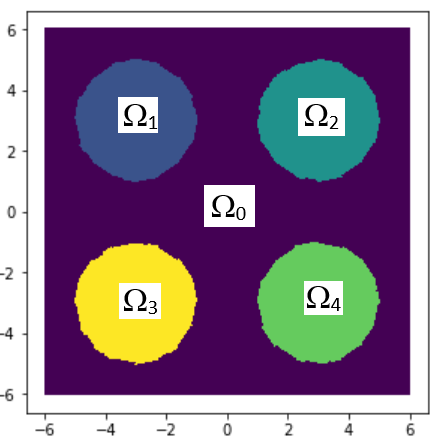

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

dim(Vh) =  4062


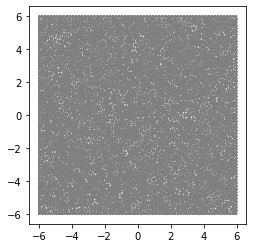

In [ ]:
A = Point(-6, -6)
B = Point(6, 6)

domain = Rectangle(A, B)

circ_rad = 2
circ1 = Circle(Point(3.0, 3.0),circ_rad) # top right circle
circ2 = Circle(Point(-3.0, 3.0),circ_rad) # top left circle
circ3 = Circle(Point(3.0, -3.0),circ_rad) # bottom right circle
circ4 = Circle(Point(-3.0, -3.0),circ_rad) # bottom left circle

# Make subdomain from mesh elements

domain.set_subdomain(1, circ1)
domain.set_subdomain(2, circ2)
domain.set_subdomain(3, circ3)
domain.set_subdomain(4, circ4)

# Generate Mesh
mesh = generate_mesh(domain, 50)
plot(mesh)
#
d = 1
Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())

In [ ]:
# Define input data
k0 = Constant(0.60)
k1 = Constant(400)
g_B = Constant(0.0)
g_T = Constant(10.0)
T_L = Constant(295.0)
T_R = Constant(375.0)
f   = Constant(0.0)
f1   = Constant(100.0)

In [ ]:
#
#  Define Dirichlet boundary condition
#
def Left(x, on_boundary):
  return on_boundary and near(x[0] , -6)

bc_1 = DirichletBC(Vh, T_L, Left)
#
def Right(x, on_boundary):
  return on_boundary and near(x[0] , 6)

bc_2 = DirichletBC(Vh, T_R, Right)
#
bcs = [bc_1, bc_2]

In [ ]:
#
# Define subdomains labels
#
class Top_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] - 3)**2 + (x[1] - 3)**2)
    return (r < circ_rad * 1.0001)

class Top_Left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +3)**2 + (x[1] - 3)**2)
    return (r < circ_rad * 1.0001)

class Bottom_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] -3)**2 + (x[1] + 3)**2)
    return (r < circ_rad * 1.0001)

class Bottom_Left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +3)**2 + (x[1] + 3)**2)
    return (r < circ_rad * 1.0001)
#
# Initialize sub-domain instances
top_right_hole = Top_Right_hole()
top_left_hole = Top_Left_hole()
bottom_right_hole = Bottom_Right_hole()
bottom_left_hole = Bottom_Left_hole()
#
# Define subdomains
subdomain_markers = MeshFunction('size_t', mesh, 2, mesh.domains())

# mark the entire subdomains as 0
subdomain_markers.set_all(0)
#
# Mark the subdomains  1
top_right_hole.mark(subdomain_markers, 1)
top_left_hole.mark(subdomain_markers , 1)
bottom_right_hole.mark(subdomain_markers ,1)
bottom_left_hole.mark(subdomain_markers , 1)

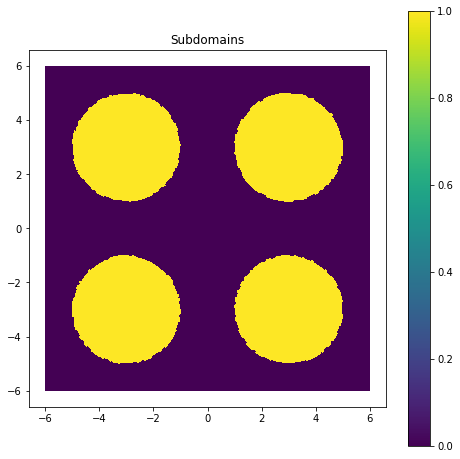

In [ ]:
# Plot subdomains
plt.figure(figsize=(8,8))
c = plot(subdomain_markers, title="Subdomains")
plt.colorbar(c)

In [ ]:
#
# Define boundary labels
#
class Bottom(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], -6.0)

class Top(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], 6.0)

# Initialize sub-domain instances
top = Top()
bottom = Bottom()
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0
boundaries.set_all(0)
#
# Mark the boundaries 2 and 3
top.mark(boundaries, 2)
bottom.mark(boundaries, 3)

In [ ]:
# Define the integration on boundaries and subdomains
#
dx=Measure('dx', domain=mesh, subdomain_data=subdomain_markers)
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

In [ ]:
# Define variational form
u = TrialFunction(Vh)
v = TestFunction(Vh)

a = inner(k0*grad(u), grad(v))*dx(0) + inner(k1*grad(u), grad(v))*dx(1)
L = f*v*dx(0) + f1*v*dx(1) + g_T*v*ds(2) + g_B*v*ds(3)

In [ ]:
# Solve problem
u = Function(Vh)
solve(a == L, u, bcs)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


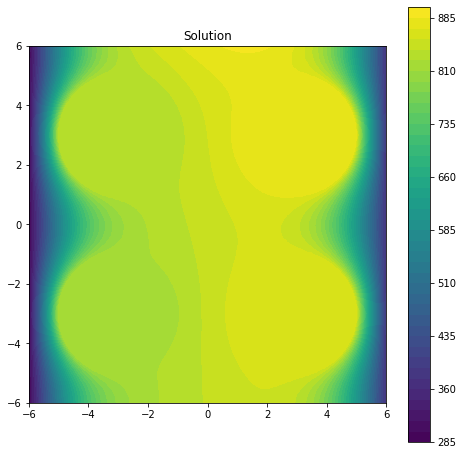

In [ ]:
# Plot solution
plt.figure(figsize=(8,8))
c = plot(u, title="Solution")
plt.colorbar(c)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


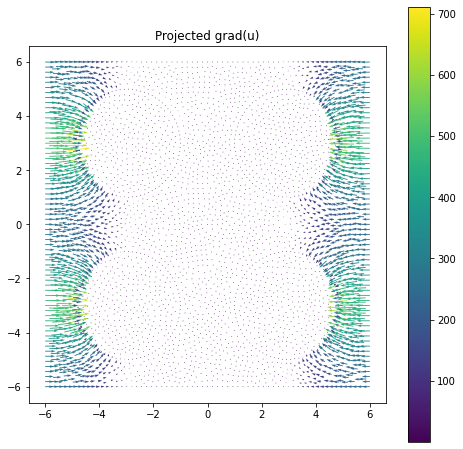

In [ ]:
plt.figure(figsize=(8,8))
p = plot(grad(u), title="Projected grad(u)")
plt.colorbar(p)